In [1]:
# py27 compatability
from __future__ import print_function
from __future__ import division
# load packages
import numpy as np                                          # advanced array functions
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from matplotlib.ticker import ScalarFormatter
# configure matplotlib
%matplotlib inline
import seaborn as sns                                       # statistics / plotting
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm_notebook                              # progress bar
import sspals
from mc_positronium import *

## Ps conversion

In [2]:
# simulate Ps converter
sim1 = Ps_converter(1e5, T=600)

## Laser Interaction

In [3]:
# excitation threshold
ol_threshold = 0.001

In [4]:
# SSPALS spectrum
laser_off = sim1['time of death']
# convolve
dt = 1e-9
bins = np.arange(-5e-8, 8e-7, dt)
pwo = detector(np.arange(-1e-8, 2e-7, dt), 1e-8)
lt_off = np.histogram(laser_off.values, bins=bins, density=False)[0]
# background
spectra_off = np.convolve(lt_off, pwo)
spectra_off = spectra_off / max(spectra_off)
limits = [-1.0E-8, 3.5e-8, 7e-7] # cfd triggers on leading edge, around 5ns before positrons arrive
fb = sspals.sspals_1D(spectra_off, dt, limits=limits)['DF'][0]

## Lamb dip

In [5]:
lyman_a = Spectroscopy(lambda_0=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))

In [6]:
wav_vals = np.arange(2.428e-7, 2.432e-7, 2e-12)
# REMPI signal
ex_eff = 1.0
S_sgl = []
S_dbl = []
bw_vals = np.array([1e11, 3.3e10, 1.0e10])
for bw in tqdm_notebook(bw_vals, desc='bandwidth'):
    for wav in tqdm_notebook(wav_vals, desc='wavelength', leave=False):
        # first laser
        lz_a = Laser(wavelength=wav, trigger=1.5e-8, bandwidth=bw)
        df = lyman_a.photoionize(sim1, lz_a, ol_threshold, ex_eff=ex_eff)
        laser_on = df['time of death']
        lt = np.histogram(laser_on.values, bins=bins, density=False)[0]
        ## sspals spectrum
        spectra_on = np.convolve(lt, pwo)
        spectra_on = spectra_on / max(spectra_on)
        ## delayed fraction
        fd = sspals.sspals_1D(spectra_on, dt, limits=limits)['DF'][0]
        ## background subtraction
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_sgl.append(S)    
        
        # retro reflected  
        lz_b = Laser(wavelength=wav, trigger=1.6e-8, bandwidth=bw)
        df = lyman_a.photoionize(df, lz_b, ol_threshold, retro=True, ex_eff=ex_eff)
        laser_on = df['time of death']
        lt = np.histogram(laser_on.values, bins=bins, density=False)[0]
        ## sspals spectrum
        spectra_on = np.convolve(lt, pwo)
        spectra_on = spectra_on / max(spectra_on)
        ## delayed fraction
        fd = sspals.sspals_1D(spectra_on, dt, limits=limits)['DF'][0]
        ## background subtraction
        S = sspals.signal(fd, 0, fb, 0)[0]
        S_dbl.append(S)
S_sgl = np.array(S_sgl).reshape((len(bw_vals), -1))
S_dbl = np.array(S_dbl).reshape((len(bw_vals), -1))

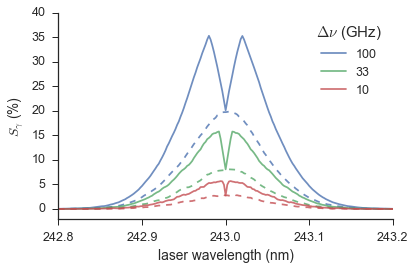

In [7]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# bandwidth
for i, bw in enumerate(bw_vals):
    p1 = ax.plot(wav_vals *1e9, S_dbl[i], '-', alpha=0.8, label='%.d'%(bw*1e-9))
    p2 = ax.plot(wav_vals *1e9, S_sgl[i], '--', alpha=0.8, color=p1[0].get_color())
ax.set_xlabel('laser wavelength (nm)')
ax.set_ylabel(r'$S_\gamma$ (%)')
ax.legend(title=r'$\Delta \nu$ (GHz)')

# format
ax.set_xlim(242.8, 243.2)
ax.set_xticks([242.8, 242.9, 243.0, 243.1, 243.2])
#ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylim(-2, 40)
x_formatter = ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
sns.despine()

# output
plt.tight_layout()
plt.show()